# Plate Tectonic Stats

Basic kinematic information on:

1. MOR length
2. Spreading rates
3. Crustal production
4. Subduction convergence rates

This notebooks requires [PlateTectonicTools](https://github.com/EarthByte/PlateTectonicTools/)

In [30]:
from multiprocessing import Pool, cpu_count
import numpy as np
import pygplates
import ptt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import warnings
from scipy import ndimage
%matplotlib inline
# plt.style.use('ggplot')


# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# reconstruction time steps and spacing
min_time = 0
max_time = 230
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)


In [31]:
input_directory = "../data/"

rotation_model = pygplates.RotationModel(input_directory+'Global_EarthByte_230-0Ma_GK07_AREPS.rot')
coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"



topology_filenames = [
    input_directory+"Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz",
    input_directory+"Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz"
]

topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    topology_features.add( pygplates.FeatureCollection(topology_filename) )

In [39]:
def update_progress(progress):
    from IPython.display import clear_output
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    
    bar_length = 20
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [40]:
def plate_tectonic_stats(reconstruction_time):
    
    # calculate ridge spreading rates
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ridge_data = ptt.ridge_spreading_rate.spreading_rates(
            rotation_model,
            topology_features,
            reconstruction_time,
            tessellation_threshold_radians,
            [pygplates.FeatureType.gpml_mid_ocean_ridge],
            anchor_plate_id=0)
        ridge_data = np.vstack(ridge_data)
        ridge_data = ridge_data[ridge_data[:,2] >= 0]
        ridge_lon = ridge_data[:,0]
        ridge_lat = ridge_data[:,1]
        ridge_vel = ridge_data[:,2]*1e-2 # m/yr
        ridge_len = np.radians(ridge_data[:,3]) * 1e3 * pygplates.Earth.mean_radius_in_kms

    ridge_len_sum = np.sum(ridge_len)
    ridge_vel_mean, ridge_vel_std = np.mean(ridge_vel), np.std(ridge_vel)
        
    # crustal surface area produced over 1 yr
    ridge_surface_area = np.sum(ridge_vel * ridge_len)
    
    # calculate subduction convergence
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        subduction_data = ptt.subduction_convergence.subduction_convergence(
            rotation_model,
            topology_features,
            tessellation_threshold_radians,
            reconstruction_time,
            anchor_plate_id=0)
        subduction_data = np.vstack(subduction_data)
        subduction_lon  = subduction_data[:,0]
        subduction_lat  = subduction_data[:,1]
        subduction_len  = np.radians(subduction_data[:,6]) * 1e3 * pygplates.Earth.mean_radius_in_kms
    
    subd_len_sum = np.sum(subduction_len)
        
    # protect against "negative" subduction
    subduction_data[:,2] = np.clip(subduction_data[:,2], 0.0, 1e99)
    subduction_vel = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
    subd_vel_mean, subd_vel_std = np.mean(subduction_vel), np.std(subduction_vel)
    
    # area subducted by trenches over 1 yr
    subd_surface_area = np.sum(subduction_vel * subduction_len)

    return(ridge_len_sum, ridge_vel_mean, ridge_vel_std, ridge_surface_area, \
           subd_len_sum,  subd_vel_mean,   subd_vel_std, subd_surface_area)

## Run 

In [41]:
stats = np.zeros((8,reconstruction_times.size))

for t, reconstruction_time in enumerate(reconstruction_times):
    stats[:,t] = plate_tectonic_stats(reconstruction_time)
    update_progress(float(t+1)/reconstruction_times.size)

Progress: [####################] 100.0%


## Create some plots

In [44]:
def smooth_1D(array, sigma=3.0):
    """ Gaussian filter with standard deviation """
    return ndimage.gaussian_filter1d(array, sigma)

def save_xy_data(filename, **kwargs):
    header = ""
    output = []
    for arg in kwargs:
        val = kwargs[arg]
        header += "{},".format(str(arg))
        output.append(val)
    output = np.column_stack(output)
    np.savetxt(filename, output, delimiter=',', fmt='%g', header=header[:-1])

stats_smooth = smooth_1D(stats)

In [46]:
# unpack stats
ridge_len_sum      = stats_smooth[0] * 1e-3 # m to km
ridge_vel_mean     = stats_smooth[1] * 100  # m/yr to cm/yr
ridge_vel_std      = stats_smooth[2] * 100  # m/yr to cm/yr
ridge_surface_area = stats_smooth[3] * 1e-6 # m^2/a to km^2/a
subd_len_sum       = stats_smooth[4] * 1e-3 # m to km
subd_vel_mean      = stats_smooth[5] * 100  # m/yr to cm/yr
subd_vel_std       = stats_smooth[6] * 100  # m/yr to cm/yr
subd_surface_area  = stats_smooth[7] * 1e-6 # m^2 /a to km^2/a

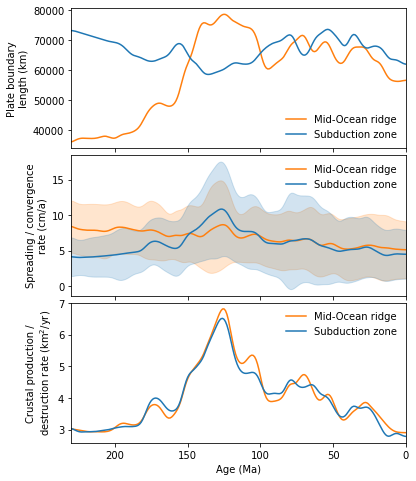

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(6,8))
fig.subplots_adjust(hspace=0.05)
n_axes = len(axes)

axes[0].set_ylabel('Plate boundary\nlength (km)')
ln1, = axes[0].plot(reconstruction_times, ridge_len_sum, c='C1',  label="Mid-Ocean ridge")
ln2, = axes[0].plot(reconstruction_times, subd_len_sum, c='C0', label='Subduction zone')
axes[0].legend(loc='lower right', frameon=False)

axes[1].set_ylabel('Spreading / convergence\nrate (cm/a)')
axes[1].fill_between(reconstruction_times, ridge_vel_mean-ridge_vel_std, ridge_vel_mean+ridge_vel_std,
                     edgecolor='k', color='C1', alpha=0.2)
axes[1].fill_between(reconstruction_times, subd_vel_mean-subd_vel_std, subd_vel_mean+subd_vel_std,
                     edgecolor='k', color='C0', alpha=0.2)
axes[1].plot(reconstruction_times, ridge_vel_mean, c='C1', label="Mid-Ocean ridge")
axes[1].plot(reconstruction_times, subd_vel_mean, c='C0', label="Subduction zone")
axes[1].legend(loc='upper right', frameon=False)

axes[2].set_ylabel('Crustal production /\ndestruction rate (km$^2$/yr)')
axes[2].plot(reconstruction_times, ridge_surface_area, c='C1', label="Mid-Ocean ridge")
axes[2].plot(reconstruction_times, subd_surface_area, c='C0', label='Subduction zone')
axes[2].legend(loc='upper right', frameon=False)



for i, ax in enumerate(axes):
    ax.set_xlim(max_time, min_time)
    if i < n_axes-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Age (Ma)")

fig.savefig("plate_tectonic_stats.pdf", dpi=300, bbox_inches='tight')


# save xy data
save_xy_data('plate_tectonic_stats.csv',
            time = reconstruction_times,
            ridge_length       = ridge_len_sum,
            ridge_vel_mean     = ridge_vel_mean,
            ridge_vel_std      = ridge_vel_std,
            ridge_surface_area = ridge_surface_area,
            subduction_length       = subd_len_sum,
            subduction_vel_mean     = subd_vel_mean,
            subduction_vel_std      = subd_vel_std,
            subduction_surface_area = subd_surface_area)